# A Basic Neural Network with back-propegation #

### Intro: ###

Hi! In this network, I'll walk you through implementing a basic neural network in Python, from scratch!
Our goal is to make a neural network that will predict an arbitary array of 4 numbers, given 4 different inputs. Lets dive in!

#### Prerequisites: ####
Knowledge of Python and general computer science principles, along with high-school calculus.

### High Level Overview of Neural Networks and back-propegation: ###

Our network is designed to take some input data, run computations on it to produce a desired output, and then update its computations, (more specifically the parameters), based on how wrong its output is. It does this until the output is close to what we want. We don't tell it how to get to the output, because we want it to learn on its own.

First, we can measure how "wrong" the output of the neural network is compared to the output we desire using a **loss function**. There are many loss functions; here we used the mean squared error (MSE). The MSE computes the sum of squared differences between our network's predicted values and the actual values.

With the loss function, we can write an algorithm that trains our network by adjusting the weights of the computations at each node slightly to minimize the loss function. This is called **backpropagation**.

How do we do that? Well, we need to know how much each node affects the output. That's called the **gradient**, and we can find it by calculating partial derivatives of the loss function with respect to each weight; these concepts are from calculus. I won't go into detail here, but if you'd like to learn more, I highly recommend this series by [3blue1brown](https://www.youtube.com/watch?v=WUvTyaaNkzM&list=PL0-GT3co4r2wlh6UHTUeQsrf3mlS2lk6x).

We start at the last node in our network, visiting every node in reverse topological order and updating the weights by a small amount in the direction that reduces the error, as indicated by the gradient.

Once we have visited all nodes and updated their weights, we do the whole process over: running the network, calculating the loss function, backpropagating, and updating their weights based on these gradients, and so on.

We do this for a set amount of times, or until our output looks similar enough to the desired data we were aiming for.


# Implementation #

## Step 1. import Libraries ##

In [12]:
# Import relevant libraries 
import random
import math

## Step 2. Create a Value Class ##

First, we create a class called Value. (A class is a custom data structure that bundles functions, behavior, and data together.) We do this to keep our code more organized and reusable.

In this class:

1. The ```data``` attribute stores the scalar value each node holds.
2. The ``grad`` attribute stores the gradient of that value, which represents how a unit change in that value affects the output (the derivative).
3. The ``_prev`` attribute stores the parent nodes—these are the Value objects from which the current value is derived during the network's forward pass. (The nodes that point to this node).
4. The ``_backward`` attribute is a function that, once executed, will calculate the gradient of the node with respect to each of its parent nodes. This will help us during the backpropagation process coming up.
The arithmetic operations (__add__, __mul__, etc.) allow us to perform math operations with the objects of our Value class.
5. The ``tanh`` and exp are math functions that further help our function later on. tanh (hyperbolic tangent function) is a function that takes any input and maps it to a value between -1 and 1, which can be the output or activation of the neuron.

### Backpropagation ###
7. The ``backward()`` method topologically sorts the nodes and visits them one by one in reverse order to update the gradient in a way that minimizes the loss function. This is the secret sauce that makes these Neural networks able to learn.

(Optional additions)

7. The ```_op``` attribute records the operation that created this node (addition, multiplication, etc.), which is useful for visualizing the network.
8. The ```label``` attribute is optional and helps us identify the nodes and visualize our graph.


In [13]:
# Value Class

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # Initialize the Value object with data, gradient, backward function, previous values, operation, and label
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        # Represent the Value object with its data
        return f"Value(data={self.data})"

    # Addition operation
    def __add__(self, other):
        # Ensure 'other' is a Value object
        other = other if isinstance(other, Value) else Value(other)
        # Create a new Value object as the sum of self and other
        out = Value(self.data + other.data, (self, other), '+')

        # Define the backward pass for addition
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    # Multiplication operation
    def __mul__(self, other):
        # Ensure 'other' is a Value object
        other = other if isinstance(other, Value) else Value(other)
        # Create a new Value object as the product of self and other
        out = Value(self.data * other.data, (self, other), '*')

        # Define the backward pass for multiplication
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    # Exponentiation operation
    def __pow__(self, other):
        # Ensure 'other' is an int or float
        assert isinstance(other, (int, float)), "only supports int/float powers"
        # Create a new Value object as self raised to the power of other
        out = Value(self.data ** other, (self,), f'**{other}')

        # Define the backward pass for exponentiation
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    # Multiplication with reversed operands (other * self)
    def __rmul__(self, other):
        return self * other

    # Division operation (self / other)
    def __truediv__(self, other):
        return self * other ** -1

    # Negation operation (-self)
    def __neg__(self):
        return self * -1

    # Subtraction operation (self - other)
    def __sub__(self, other):
        return self + (-other)
    
    # Hyperbolic tangent function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        # Create a new Value object as the tanh of self
        out = Value(t, (self,), 'tanh')

        # Define the backward pass for tanh
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    # Exponential function
    def exp(self):
        x = self.data
        # Create a new Value object as the exponential of self
        out = Value(math.exp(x), (self,), 'exp')

        # Define the backward pass for exp
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    # Backward pass for computing gradients
    def backward(self):
        # Topological ordering of nodes
        topo = []
        visited = set()
        
        # Helper function to build the topological order
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        # Build the topological order starting from self
        build_topo(self)

        # Initialize the gradient of self to 1.0
        self.grad = 1.0
        
        # Traverse nodes in reverse topological order and call their backward functions
        for node in reversed(topo):
            node._backward()


## Step 2.5 (Optional) Function to Visualize our network ##

This is an optional implementation of a function that will draw our network, useful for visualization and debugging, but not necessary.

In [3]:
# Function For Drawing Network
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR', 'size': '32,18'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Step 3. Build the Neural Network Architecture ##

We now move on to creating our Neural Network which consists of Neurons, Layers, and an MLP (Multi-layer perceptron). 

Each Neuron object has a weight and a bias. It computes the weighted sum of all its inputs and adds the bias on top, and then passes the data forward. 

The layer object is made op of several neurons. It handles the forward pass for all its respective neurons to the next layer(s). 

The MLP class gives us MLP objects which represent several layers of neurons, "chained" together to take in an input and pass it through the layers.

In [4]:
# Neural Network Components 

class Neuron:
    # Initialize a neuron with a specified number of inputs (nin)
    def __init__(self, nin):
        # Create a list of weights (w) with random values between -1 and 1
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        # Create a bias term (b) with a random value between -1 and 1
        self.b = Value(random.uniform(-1,1))

    # Define the neuron's forward pass behavior
    def __call__(self, x):
        # Calculate the weighted sum of the inputs (w * x) and add the bias term (b)
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        # Apply the hyperbolic tangent (tanh) activation function to the result
        out = act.tanh()
        return out

    # Return a list of the neuron's parameters (weights and bias)
    def parameters(self):
        return self.w + [self.b]


class Layer:
    # Initialize a layer with a specified number of inputs (nin) and outputs (nout)
    def __init__(self, nin, nout):
        # Create a list of neurons, each with the specified number of inputs
        self.neurons = [Neuron(nin) for _ in range(nout)]

    # Define the layer's forward pass behavior
    def __call__(self, x):
        # Calculate the output of each neuron in the layer
        outs = [n(x) for n in self.neurons]
        # If the layer has only one neuron, return its output directly
        # Otherwise, return a list of outputs
        return outs[0] if len(outs) == 1 else outs

    # Return a list of the layer's parameters (all neuron parameters)
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    # Initialize a multi-layer perceptron (MLP) with a specified number of inputs (nin) and output sizes (nouts)
    def __init__(self, nin, nouts):
        # Create a list of layer sizes, including the input size and all output sizes
        sz = [nin] + nouts
        # Create a list of layers, each with the corresponding input and output sizes
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    # Define the MLP's forward pass behavior
    def __call__(self, x):
        # Iterate through each layer, applying its forward pass behavior
        for layer in self.layers:
            x = layer(x)
        return x

    # Return a list of the MLP's parameters (all layer parameters)
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

## Step 4. Create a Network ##

Now we actually create our network, n, which is an MLP object.

In [5]:
# example data set
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [6]:
# create a neural network with 3 layers
# 2 hidden layers with 4 neurons each
# 1 output layer with a single neuron
n = MLP(3, [4, 4, 1])

# pass our input data into the network
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9569039945027088),
 Value(data=0.8937842926801886),
 Value(data=0.9231146807322822),
 Value(data=0.9433068396639074)]

Here is the corrected version with improved spelling and grammar:

Our network takes an input array with three numbers, passes it through each layer while transforming it according to its parameters, and produces a single final output.

Above, we passed four separate inputs into it and received four different outputs. Most of which are not close to our desired outputs as specified in ```ys```. 

If we want to visualize our network, this is what it would look like (for only one input):

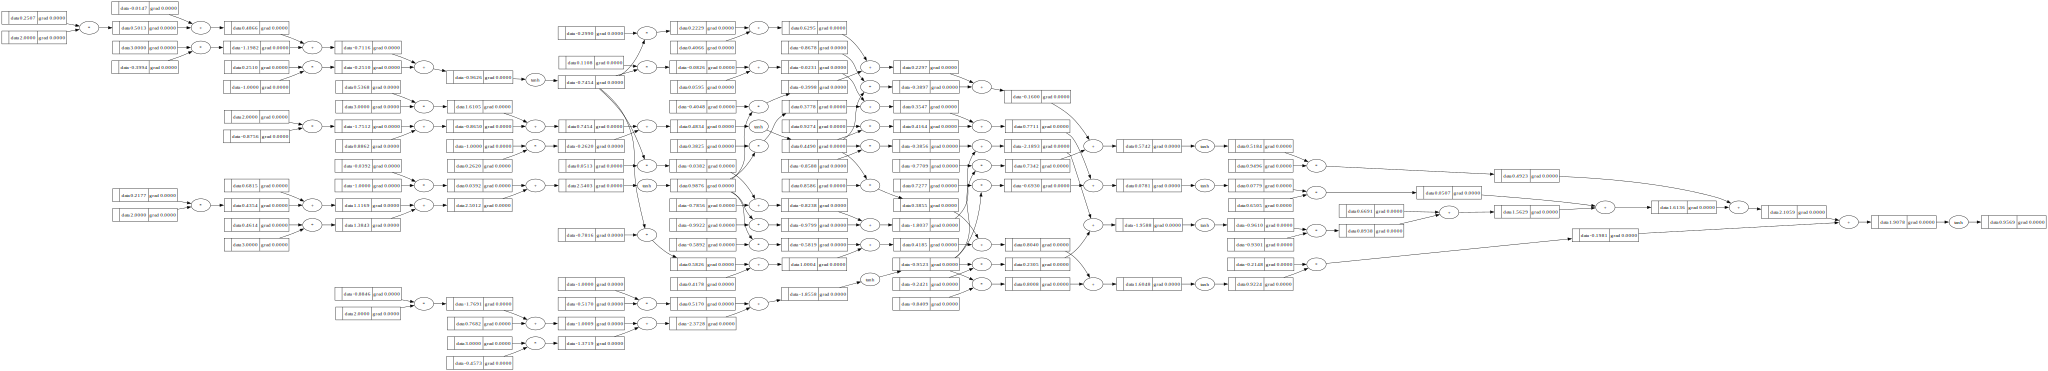

In [7]:
draw_dot(n(xs[0]))

* Note: Our visualization shows every operation (like __add__, __mul__) and every intermediate node, so out graph does not look as neatly structured as the description above.

We can see that the gradients have not been set. That comes next 

## Step 5. Training the Network ##

The following code passes the input through our network, calculates the loss function, and updates the parameters of the network based on the direction of the gradient at each node. It does this 100 times, giving us 100 sets of predictions. 

In [8]:
for k in range(100):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update 
    for p in n.parameters():
        p.data += -0.05 * p.grad

    
    # print our loss function at each step so show it getting smaller.
    if 0 <= k <= 2 or 97 <= k <= 100:
        print(k+1,"The loss is",loss.data)
    elif k == 3:
        print(".\n"*3)

1 The loss is 7.289860402568945
2 The loss is 6.818579660475097
3 The loss is 5.284759185141115
.
.
.

98 The loss is 0.009083570382596783
99 The loss is 0.008929336136907823
100 The loss is 0.008779893838880995


We can see that starting out the loss function is quite large, but it gets a little smaller after each iteration, until the final iteration when it is very small. As we'll see below, our predictions have gotten much closer to our original target values :)

In [9]:
ypred # the predicted values from the network

[Value(data=0.9633349876560496),
 Value(data=-0.9389606824101403),
 Value(data=-0.9399416148148756),
 Value(data=0.9898628018753486)]

In [10]:
ys # the target values

[1.0, -1.0, -1.0, 1.0]

Thats it! If you're looking for more resources on machine learning and neural networks, here are my recommendations!
1. [Coursera, Stanford, Deeplearning.ai  - Machine Learning Specialization]("https://www.coursera.org/specializations/machine-learning-introduction")
2. [Andrej Karpathy on youtube]("https://www.youtube.com/@AndrejKarpathy/videos")
3. [Understanding AI from Scratch – Neural Networks Course by freecodecamp.org]("https://www.youtube.com/watch?v=VgzHT9quo5c")